In [1]:
import copy
import pandas
import numpy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import euclidean_distances

"""
This tutorial shows how to generate adversarial examples
using FGSM in black-box setting.
The original paper can be found at:
https://arxiv.org/abs/1602.02697
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from six.moves import xrange

import logging
import tensorflow as tf
from tensorflow.python.platform import flags

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils import to_categorical
from cleverhans.utils import set_log_level
from cleverhans.utils_tf import model_train, model_eval, batch_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks_tf import jacobian_graph, jacobian_augmentation

from cleverhans_tutorials.tutorial_models import make_basic_cnn, MLP
from cleverhans_tutorials.tutorial_models import Flatten, Linear, ReLU, Softmax
from cleverhans.utils import TemporaryLogLevel

from lad import lad_Thibault
from scipy.spatial.distance import euclidean

FLAGS = flags.FLAGS

# Functions

## Data

In [10]:
'''
MOONS
'''
def get_moon():
    X, y = make_moons(noise=0.3, random_state=1, n_samples=10000)
    y2 = numpy.zeros((X.shape[0],2))
    for k in range(len(y)):
        y2[k][y[k]] = 1
    return X, y2

def get_german():
    path_dataset='data/germancredit.csv'
    X = pandas.read_csv(path_dataset, delimiter=",", index_col=0)
    y = X.label
    y = y - 1
    X = X.iloc[:,X.columns != 'label']
    X = (X-X.mean())/X.std()
    y2 = numpy.zeros((X.shape[0],2)) #2=  nb de classes
    for k in range(len(y)):
        y2[k][y[k]] = 1
    return numpy.array(X), numpy.array(y2)

DATASETS_ = {'moons':get_moon,
            'german': get_german}


## Training a black-box

In [3]:
'''
PAPERNOT BB
'''
def Papernot_bbox(sess, x, y, X_train, Y_train, X_test, Y_test,
              nb_epochs, batch_size, learning_rate,
              rng):
    """
    Define and train a model that simulates the "remote"
    black-box oracle described in the original paper.
    :param sess: the TF session
    :param x: the input placeholder for MNIST
    :param y: the ouput placeholder for MNIST
    :param X_train: the training data for the oracle
    :param Y_train: the training labels for the oracle
    :param X_test: the testing data for the oracle
    :param Y_test: the testing labels for the oracle
    :param nb_epochs: number of epochs to train model
    :param batch_size: size of training batches
    :param learning_rate: learning rate for training
    :param rng: numpy.random.RandomState
    :return:
    """

    # Define TF model graph (for the black-box model)
    model = make_basic_cnn()
    predictions = model(x)
    print("Defined TensorFlow model graph.")

    # Train an MNIST model
    train_params = {
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
    model_train(sess, x, y, predictions, X_train, Y_train,
                args=train_params, rng=rng)

    # Print out the accuracy on legitimate data
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy of black-box on legitimate test '
          'examples: ' + str(accuracy))

    return model, predictions, accuracy

def RF_bbox(X_train, Y_train, X_test, Y_test):
    # Define RF model graph (for the black-box model)

    model = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, Y_train)
    
    # Print out the accuracy on legitimate data
    #predictions = model.predict_proba(X_test)[1] TEST CHANGER PREDICTIONS > FONCTION
    predictions=lambda x: model.predict_proba(x)[1] #predict_proba required ou alors changer du code (argmax et compagnie) de papernot
    
    accuracy = accuracy_score(Y_test, model.predict(X_test))
    #roc_auc = roc_auc_score(Y_test, predictions[1][:,1])
    print('Test accuracy of black-box on legitimate test '
          'examples: ' + str(accuracy))
    #print('Test ROC AUC of black-box on legitimate test ' 'examples: ' + str(roc_auc))
        
    
    return model, predictions, accuracy
    
BB_MODELS_ = {'dnn': Papernot_bbox,
            'rf': RF_bbox}
#ne pas utiliser dnn ca marche pas pour le moment

## Papernot Surrogate

In [12]:
def setup_tutorial():
    """
    Helper function to check correct configuration of tf for tutorial
    :return: True if setup checks completed
    """

    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    return True
def substitute_model(img_rows=1, img_cols=2, nb_classes=2):
    """
    Defines the model architecture to be used by the substitute. Use
    the example model interface.
    :param img_rows: number of rows in input
    :param img_cols: number of columns in input
    :param nb_classes: number of classes in output
    :return: tensorflow model
    """
    input_shape = (None, img_rows, img_cols, 1) #on garde format d'origine parce qu'on comprend pas grand chose mais on change valeurs

    # Define a fully connected model (it's different than the black-box)
    '''layers = [Flatten(),
              Linear(200),
              ReLU(),
              Linear(200),
              ReLU(),
              Linear(nb_classes),
              Softmax()]'''
    layers = [Flatten(), Linear(nb_classes), Softmax()] #surrogate simplifié

    return MLP(layers, input_shape)


def train_sub(sess, x, y, bb_model, X_sub, Y_sub, nb_classes,
              nb_epochs_s, batch_size, learning_rate, data_aug, lmbda,
              rng):
    """
    This function creates the substitute by alternatively
    augmenting the training data and training the substitute.
    :param sess: TF session
    :param x: input TF placeholder
    :param y: output TF placeholder
    :param bbox_preds: output of black-box model predictions
    :param X_sub: initial substitute training data
    :param Y_sub: initial substitute training labels
    :param nb_classes: number of output classes
    :param nb_epochs_s: number of epochs to train substitute model
    :param batch_size: size of training batches
    :param learning_rate: learning rate for training
    :param data_aug: number of times substitute training data is augmented
    :param lmbda: lambda from arxiv.org/abs/1602.02697
    :param rng: numpy.random.RandomState instance
    :return:
    """
    # Define TF model graph (for the black-box model)
    model_sub = substitute_model(img_cols=X_sub.shape[1])
    preds_sub = model_sub(x)
    print("Defined TensorFlow model graph for the substitute.")

    # Define the Jacobian symbolically using TensorFlow
    grads = jacobian_graph(preds_sub, x, nb_classes)
    # Train the substitute and augment dataset alternatively
    for rho in xrange(data_aug):
        print("Substitute training epoch #" + str(rho))
        train_params = {
            'nb_epochs': nb_epochs_s,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }
        with TemporaryLogLevel(logging.WARNING, "cleverhans.utils.tf"):
            model_train(sess, x, y, preds_sub, X_sub,
                        to_categorical(Y_sub, nb_classes),
                        init_all=False, args=train_params, rng=rng)

        # If we are not at last substitute training iteration, augment dataset
        if rho < data_aug - 1:
            print("Augmenting substitute training data.")
            # Perform the Jacobian augmentation
            lmbda_coef = 2 * int(int(rho / 3) != 0) - 1
            X_sub = jacobian_augmentation(sess, x, X_sub, Y_sub, grads,
                                          lmbda_coef * lmbda)
            
            print("Labeling substitute training data.")
            # Label the newly generated synthetic points using the black-box
            Y_sub = numpy.hstack([Y_sub, Y_sub])
            X_sub_prev = X_sub[int(len(X_sub)/2):] #on a double le dataset donc prev = ce qu'il y a de nouveau = la moitie
            eval_params = {'batch_size': batch_size}
            
            #bbox_preds = tf.convert_to_tensor(bbox_preds, dtype=tf.float32) TEST CHANGER PREDICTIONS > FONCTION           
            #bbox_val = batch_eval2(sess, [x], [bbox_preds], [X_sub_prev], args=eval_params)[0] TEST CHANGER PREDICTIONS > FONCTION
            
            #bbox_val = bbox_preds(X_sub_prev) #normalement batch eval sert juste à sortir les preds...?
            bbox_val = bb_model.predict(X_sub_prev)
            # Note here that we take the argmax because the adversary
            # only has access to the label (not the probabilities) output
            # by the black-box model
            Y_sub[int(len(X_sub)/2):] = numpy.argmax(bbox_val, axis=1)
    return model_sub, preds_sub 

Usage: 
print("Training the substitute model.")
    train_sub_out = train_sub(sess, x, y, bbox_preds, X_sub, Y_sub,
                              nb_classes, nb_epochs_s, batch_size,
                              learning_rate, data_aug, lmbda, rng=rng)
    model_sub, preds_sub = train_sub_out

# Our surrogate

# Local Fidelity

In [6]:
def get_random_points_hypersphere(x_center, radius_, n_points_):

        res = []
        while len(res) < n_points_:
        
            n_points_left_ = n_points_ - len(res)
            # About half the points are lost in the test hypercube => hypersphere
            lbound = numpy.repeat([x_center.values-(radius_/2.)], n_points_left_*2, axis=0)
            hbound = numpy.repeat([x_center.values+(radius_/2.)], n_points_left_*2, axis=0)
            points = numpy.random.uniform(low=lbound, high=hbound)
            # Check if x_generated is within hypersphere (if kind=='hypersphere')
            for x_generated in points:
                if euclidean(x_generated, x_center.values) < radius_:
                    res.append(x_generated)
                if len(res) == n_points_:
                    break

        return pandas.DataFrame(numpy.array(res))
    
def generate_inside_ball(center, segment=(0,1), n=1): #verifier algo comprendre racine 1/d et rapport entre segment et radius
    d = center.shape[0]
    z = numpy.random.normal(0, 1, (n, d))
    z = numpy.array([a * b / c for a, b, c in zip(z, numpy.random.uniform(*segment, n),  norm(z))])
    z = z + center
    return z 
def norm(v):
        return numpy.linalg.norm(v, ord=2, axis=1) #array of l2 norms of vectors in v

# Framework

In [56]:

def main_fidelity(radius):
    accuracies = {}
    fidelities = {}
    
    
    # Seed random number generator so tutorial is reproducible
    rng = numpy.random.RandomState([2017, 8, 30])

    # Thibault: Tensorflow stuff
    set_log_level(logging.DEBUG)
    assert setup_tutorial()
    sess = tf.Session()
    
    
    
    # Data
    X, Y = DATASETS_['german']()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    X_sub = X_test[:holdout]
    Y_sub = numpy.argmax(Y_test[:holdout], axis=1)

    ## Redefine test set as remaining samples unavailable to adversaries
    ### N.B Thibault: c'est pour le substitute de Papernot
    X_test = X_test[holdout:]
    Y_test = Y_test[holdout:]
    print("Training black box on",X_train.shape[0], "examples")
    print('Testing black box and substitute on', X_test.shape[0],' examples')
    print("Using ", holdout, " examples to start PP substitute")
    ## Define input and output TF placeholders
    ### N.B. Thibault: restes de Tensorflow, utilisé pour le substitute de Papernot...
    x = tf.placeholder(tf.float32, shape=(None, 20))
    y = tf.placeholder(tf.float32, shape=(None, 2))  
    
    
    
    # Instance to explain
    x_toexplain = pandas.Series(X_test[0]).copy()
    support_x_ = numpy.array(get_random_points_hypersphere(x_toexplain, radius_=radius, n_points_=1000))
    
    
    
    # Simulate the black-box model
    print("Preparing the black-box model.")
    prep_bbox_out = BB_MODELS_['rf'](X_train, Y_train, X_test, Y_test)
    bb_model, bbox_preds, accuracies['bbox'] = prep_bbox_out #bbox_preds fonction predict
    
    # Train PAPERNOT substitute
    print("Training the Pépèrenot substitute model.")
    train_sub_pap = train_sub(sess, x, y, bb_model, X_sub, Y_sub,
                              nb_classes, nb_epochs_s, batch_size,
                              learning_rate, data_aug, lmbda, rng=rng)
    model_sub, preds_sub = train_sub_pap
    
    #feed_dict = {x:support_x_, y:bbox_preds(support_x_)}
    
    eval_params = {'batch_size': batch_size}
    pap_acc = model_eval(sess, x, y, preds_sub, X_test, Y_test, args=eval_params) 
    pap_fid = model_eval(sess, x, y, preds_sub, support_x_, bb_model.predict(support_x_) , args=eval_params)
    accuracies['papernot'] = pap_acc
    fidelities['papernot'] = pap_fid
    
    
    # Train OUR subtitute
    '''print("Training Local Surrogate substitute model.")
    pred = bb_model.predict
    bb_model.predict = lambda x: pred(x)[:,1]
    _, train_sub_ls = lad.LocalSurrogate(pandas.DataFrame(X), blackbox=bb_model, n_support_points=100, max_depth=3).get_local_surrogate(x_toexplain)
    #ls_acc = accuracy_score(train_sub_ls.predict(X_test), Y_test)
    ls_fid = accuracy_score(train_sub_ls.predict(support_x_), bb_model.predict(support_x_))
    #accuracies['localsurrogate'] = ls_acc
    fidelities['localsurrogate'] = ls_fid
    '''

    
    # Initialize the Fast Gradient Sign Method (FGSM) attack object.
    fgsm_par = {'eps': 0.5, 'ord': numpy.inf, 'clip_min': 0., 'clip_max': 1.} #ord: norme L1, l2 ou linfini
    fgsm = FastGradientMethod(model_sub, sess=sess)

    # Craft adversarial examples using the substitute
    eval_params = {'batch_size': batch_size}
    x_adv_sub = fgsm.generate(x, **fgsm_par)

    # Evaluate the accuracy of the "black-box" model on adversarial examples
    accuracy = accuracy_score(Y_test, bb_model.predict(sess.run(x_adv_sub, feed_dict={x: X_test})))
    #model_eval(sess, x, y, bb_model.predict(x_adv_sub), X_test, Y_test,
    #                      args=eval_params)
    print('Test accuracy of oracle on adversarial examples generated '
          'using the substitute: ' + str(accuracy))
    accuracies['bbox_on_sub_adv_ex'] = accuracy
    
    return fidelities, accuracies



nb_classes=2 #
batch_size=20 #
learning_rate=0.001 #
nb_epochs=0 # Nombre d'itération bbox osef
holdout=10 # Nombre d'exemples utilisés au début pour générer data (Pap-substitute)
data_aug=6 # Nombre d'itérations d'augmentation du dataset {IMPORTANT pour Pap-substitute}
nb_epochs_s=10 # Nombre d'itérations pour train substitute
lmbda=0.1 # params exploration pour augmentation data
radius_ = 0.5 # NEW
main_fidelity(radius_)

Training black box on 800 examples
Testing black box and substitute on 190  examples
Using  10  examples to start PP substitute
Preparing the black-box model.
Test accuracy of black-box on legitimate test examples: 0.7684210526315789
Training the Pépèrenot substitute model.
Defined TensorFlow model graph for the substitute.
Substitute training epoch #0


[INFO 2018-06-27 19:18:48,802 cleverhans] Epoch 0 took 0.09415221214294434 seconds
[INFO 2018-06-27 19:18:48,803 cleverhans] Epoch 1 took 0.0005865097045898438 seconds
[INFO 2018-06-27 19:18:48,804 cleverhans] Epoch 2 took 0.00041413307189941406 seconds
[INFO 2018-06-27 19:18:48,805 cleverhans] Epoch 3 took 0.0004687309265136719 seconds
[INFO 2018-06-27 19:18:48,806 cleverhans] Epoch 4 took 0.0003383159637451172 seconds
[INFO 2018-06-27 19:18:48,806 cleverhans] Epoch 5 took 0.0003116130828857422 seconds
[INFO 2018-06-27 19:18:48,807 cleverhans] Epoch 6 took 0.0003371238708496094 seconds
[INFO 2018-06-27 19:18:48,808 cleverhans] Epoch 7 took 0.0003619194030761719 seconds
[INFO 2018-06-27 19:18:48,808 cleverhans] Epoch 8 took 0.00037288665771484375 seconds
[INFO 2018-06-27 19:18:48,809 cleverhans] Epoch 9 took 0.00038242340087890625 seconds
[INFO 2018-06-27 19:18:48,810 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #1


[INFO 2018-06-27 19:19:02,962 cleverhans] Epoch 0 took 0.09948325157165527 seconds
[INFO 2018-06-27 19:19:02,963 cleverhans] Epoch 1 took 0.0006444454193115234 seconds
[INFO 2018-06-27 19:19:02,964 cleverhans] Epoch 2 took 0.0006618499755859375 seconds
[INFO 2018-06-27 19:19:02,965 cleverhans] Epoch 3 took 0.0005359649658203125 seconds
[INFO 2018-06-27 19:19:02,966 cleverhans] Epoch 4 took 0.0004322528839111328 seconds
[INFO 2018-06-27 19:19:02,967 cleverhans] Epoch 5 took 0.0005624294281005859 seconds
[INFO 2018-06-27 19:19:02,968 cleverhans] Epoch 6 took 0.0004477500915527344 seconds
[INFO 2018-06-27 19:19:02,969 cleverhans] Epoch 7 took 0.00048160552978515625 seconds
[INFO 2018-06-27 19:19:02,969 cleverhans] Epoch 8 took 0.0003561973571777344 seconds
[INFO 2018-06-27 19:19:02,970 cleverhans] Epoch 9 took 0.0003666877746582031 seconds
[INFO 2018-06-27 19:19:02,970 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #2


[INFO 2018-06-27 19:19:29,105 cleverhans] Epoch 0 took 0.11781716346740723 seconds
[INFO 2018-06-27 19:19:29,107 cleverhans] Epoch 1 took 0.001051187515258789 seconds
[INFO 2018-06-27 19:19:29,108 cleverhans] Epoch 2 took 0.0008361339569091797 seconds
[INFO 2018-06-27 19:19:29,110 cleverhans] Epoch 3 took 0.0008704662322998047 seconds
[INFO 2018-06-27 19:19:29,111 cleverhans] Epoch 4 took 0.0007464885711669922 seconds
[INFO 2018-06-27 19:19:29,112 cleverhans] Epoch 5 took 0.0008094310760498047 seconds
[INFO 2018-06-27 19:19:29,114 cleverhans] Epoch 6 took 0.000736236572265625 seconds
[INFO 2018-06-27 19:19:29,115 cleverhans] Epoch 7 took 0.0009937286376953125 seconds
[INFO 2018-06-27 19:19:29,116 cleverhans] Epoch 8 took 0.0006339550018310547 seconds
[INFO 2018-06-27 19:19:29,117 cleverhans] Epoch 9 took 0.0006041526794433594 seconds
[INFO 2018-06-27 19:19:29,117 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #3


[INFO 2018-06-27 19:20:20,537 cleverhans] Epoch 0 took 0.10551643371582031 seconds
[INFO 2018-06-27 19:20:20,539 cleverhans] Epoch 1 took 0.0016813278198242188 seconds
[INFO 2018-06-27 19:20:20,541 cleverhans] Epoch 2 took 0.0012249946594238281 seconds
[INFO 2018-06-27 19:20:20,543 cleverhans] Epoch 3 took 0.0014140605926513672 seconds
[INFO 2018-06-27 19:20:20,545 cleverhans] Epoch 4 took 0.0013492107391357422 seconds
[INFO 2018-06-27 19:20:20,546 cleverhans] Epoch 5 took 0.0013561248779296875 seconds
[INFO 2018-06-27 19:20:20,548 cleverhans] Epoch 6 took 0.0011968612670898438 seconds
[INFO 2018-06-27 19:20:20,549 cleverhans] Epoch 7 took 0.0012660026550292969 seconds
[INFO 2018-06-27 19:20:20,551 cleverhans] Epoch 8 took 0.001201629638671875 seconds
[INFO 2018-06-27 19:20:20,553 cleverhans] Epoch 9 took 0.0015869140625 seconds
[INFO 2018-06-27 19:20:20,553 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #4


[INFO 2018-06-27 19:22:05,639 cleverhans] Epoch 0 took 0.11149215698242188 seconds
[INFO 2018-06-27 19:22:05,643 cleverhans] Epoch 1 took 0.002958536148071289 seconds
[INFO 2018-06-27 19:22:05,646 cleverhans] Epoch 2 took 0.0030336380004882812 seconds
[INFO 2018-06-27 19:22:05,650 cleverhans] Epoch 3 took 0.002886533737182617 seconds
[INFO 2018-06-27 19:22:05,654 cleverhans] Epoch 4 took 0.0033159255981445312 seconds
[INFO 2018-06-27 19:22:05,656 cleverhans] Epoch 5 took 0.002352476119995117 seconds
[INFO 2018-06-27 19:22:05,659 cleverhans] Epoch 6 took 0.0022497177124023438 seconds
[INFO 2018-06-27 19:22:05,662 cleverhans] Epoch 7 took 0.0026400089263916016 seconds
[INFO 2018-06-27 19:22:05,665 cleverhans] Epoch 8 took 0.002621889114379883 seconds
[INFO 2018-06-27 19:22:05,668 cleverhans] Epoch 9 took 0.002526998519897461 seconds
[INFO 2018-06-27 19:22:05,668 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #5


[INFO 2018-06-27 19:25:44,387 cleverhans] Epoch 0 took 0.11306524276733398 seconds
[INFO 2018-06-27 19:25:44,394 cleverhans] Epoch 1 took 0.005726814270019531 seconds
[INFO 2018-06-27 19:25:44,400 cleverhans] Epoch 2 took 0.005811214447021484 seconds
[INFO 2018-06-27 19:25:44,408 cleverhans] Epoch 3 took 0.0069124698638916016 seconds
[INFO 2018-06-27 19:25:44,414 cleverhans] Epoch 4 took 0.005264759063720703 seconds
[INFO 2018-06-27 19:25:44,419 cleverhans] Epoch 5 took 0.004702329635620117 seconds
[INFO 2018-06-27 19:25:44,424 cleverhans] Epoch 6 took 0.005049228668212891 seconds
[INFO 2018-06-27 19:25:44,430 cleverhans] Epoch 7 took 0.0050466060638427734 seconds
[INFO 2018-06-27 19:25:44,435 cleverhans] Epoch 8 took 0.004989147186279297 seconds
[INFO 2018-06-27 19:25:44,440 cleverhans] Epoch 9 took 0.004487514495849609 seconds
[INFO 2018-06-27 19:25:44,441 cleverhans] Completed model training.


Test accuracy of oracle on adversarial examples generated using the substitute: 0.7052631578947368


({'papernot': 0.379},
 {'bbox': 0.7684210526315789,
  'bbox_on_sub_adv_ex': 0.7052631578947368,
  'papernot': 0.6})


Il faut trouver une facon de faire la boucle

pour radius:
    genere black box
    genere surrogate papernot
    
    pour observation dans test:
        genere local surrogate
        evalue papernot local
        evalue local surrogate local
outputs:
papernot: {radius: [accuracy locale de chaque point}
pareil pour ls}


TODO: check histoire de boucle radius comment ca se goupille
voir si ca tourne
faire graphe...


In [15]:
# Seed random number generator so tutorial is reproducible
rng = numpy.random.RandomState([2017, 8, 30])

# Thibault: Tensorflow stuff
set_log_level(logging.DEBUG)
assert setup_tutorial()
sess = tf.Session()



# Data
X, Y = DATASETS_['german']()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)
X_sub = X_test[:holdout]
Y_sub = numpy.argmax(Y_test[:holdout], axis=1)

## Redefine test set as remaining samples unavailable to adversaries
### N.B Thibault: c'est pour le substitute de Papernot
X_test = X_test[holdout:]
Y_test = Y_test[holdout:]
print("Training black box on",X_train.shape[0], "examples")
print('Testing black box and substitute on', X_test.shape[0],' examples')
print("Using ", holdout, " examples to start PP substitute")
## Define input and output TF placeholders
### N.B. Thibault: restes de Tensorflow, utilisé pour le substitute de Papernot...
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
y = tf.placeholder(tf.float32, shape=(None, Y.shape[1]))  

# Simulate the black-box model
print("Preparing the black-box model.")
prep_bbox_out = BB_MODELS_['rf'](X_train, Y_train, X_test, Y_test)
bb_model, bbox_preds, _ = prep_bbox_out #bbox_preds fonction predict

# Train PAPERNOT substitute
print("Training the Pépèrenot substitute model.")
train_sub_pap = train_sub(sess, x, y, bb_model, X_sub, Y_sub,
                          nb_classes, nb_epochs_s, batch_size,
                          learning_rate, data_aug, lmbda, rng=rng)
model_sub, preds_sub = train_sub_pap

eval_params = {'batch_size': batch_size}
pap_acc = model_eval(sess, x, y, preds_sub, X_test, Y_test, args=eval_params) 
print(pap_acc)







Training black box on 800 examples
Testing black box and substitute on 150  examples
Using  50  examples to start PP substitute
Preparing the black-box model.
Test accuracy of black-box on legitimate test examples: 0.7933333333333333
Training the Pépèrenot substitute model.
Defined TensorFlow model graph for the substitute.
Substitute training epoch #0


[INFO 2018-06-27 15:27:02,174 cleverhans] Epoch 0 took 0.03695559501647949 seconds
[INFO 2018-06-27 15:27:02,176 cleverhans] Epoch 1 took 0.0011332035064697266 seconds
[INFO 2018-06-27 15:27:02,177 cleverhans] Epoch 2 took 0.000989675521850586 seconds
[INFO 2018-06-27 15:27:02,179 cleverhans] Epoch 3 took 0.0013225078582763672 seconds
[INFO 2018-06-27 15:27:02,181 cleverhans] Epoch 4 took 0.0011136531829833984 seconds
[INFO 2018-06-27 15:27:02,182 cleverhans] Epoch 5 took 0.001153707504272461 seconds
[INFO 2018-06-27 15:27:02,183 cleverhans] Epoch 6 took 0.0009675025939941406 seconds
[INFO 2018-06-27 15:27:02,185 cleverhans] Epoch 7 took 0.0009479522705078125 seconds
[INFO 2018-06-27 15:27:02,186 cleverhans] Epoch 8 took 0.0010585784912109375 seconds
[INFO 2018-06-27 15:27:02,187 cleverhans] Epoch 9 took 0.0010216236114501953 seconds
[INFO 2018-06-27 15:27:02,188 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #1


[INFO 2018-06-27 15:27:06,947 cleverhans] Epoch 0 took 0.033199310302734375 seconds
[INFO 2018-06-27 15:27:06,950 cleverhans] Epoch 1 took 0.001959562301635742 seconds
[INFO 2018-06-27 15:27:06,953 cleverhans] Epoch 2 took 0.0021190643310546875 seconds
[INFO 2018-06-27 15:27:06,955 cleverhans] Epoch 3 took 0.00176239013671875 seconds
[INFO 2018-06-27 15:27:06,957 cleverhans] Epoch 4 took 0.0016868114471435547 seconds
[INFO 2018-06-27 15:27:06,959 cleverhans] Epoch 5 took 0.0018417835235595703 seconds
[INFO 2018-06-27 15:27:06,961 cleverhans] Epoch 6 took 0.0018846988677978516 seconds
[INFO 2018-06-27 15:27:06,964 cleverhans] Epoch 7 took 0.002386331558227539 seconds
[INFO 2018-06-27 15:27:06,966 cleverhans] Epoch 8 took 0.0018665790557861328 seconds
[INFO 2018-06-27 15:27:06,969 cleverhans] Epoch 9 took 0.0019054412841796875 seconds
[INFO 2018-06-27 15:27:06,969 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #2


[INFO 2018-06-27 15:27:17,211 cleverhans] Epoch 0 took 0.03695535659790039 seconds
[INFO 2018-06-27 15:27:17,214 cleverhans] Epoch 1 took 0.003141164779663086 seconds
[INFO 2018-06-27 15:27:17,218 cleverhans] Epoch 2 took 0.0033500194549560547 seconds
[INFO 2018-06-27 15:27:17,222 cleverhans] Epoch 3 took 0.0036220550537109375 seconds
[INFO 2018-06-27 15:27:17,225 cleverhans] Epoch 4 took 0.0028874874114990234 seconds
[INFO 2018-06-27 15:27:17,229 cleverhans] Epoch 5 took 0.003096342086791992 seconds
[INFO 2018-06-27 15:27:17,232 cleverhans] Epoch 6 took 0.002938985824584961 seconds
[INFO 2018-06-27 15:27:17,236 cleverhans] Epoch 7 took 0.003136157989501953 seconds
[INFO 2018-06-27 15:27:17,239 cleverhans] Epoch 8 took 0.0031452178955078125 seconds
[INFO 2018-06-27 15:27:17,244 cleverhans] Epoch 9 took 0.004333972930908203 seconds
[INFO 2018-06-27 15:27:17,245 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #3


[INFO 2018-06-27 15:27:39,082 cleverhans] Epoch 0 took 0.04013848304748535 seconds
[INFO 2018-06-27 15:27:39,088 cleverhans] Epoch 1 took 0.006196022033691406 seconds
[INFO 2018-06-27 15:27:39,096 cleverhans] Epoch 2 took 0.007002592086791992 seconds
[INFO 2018-06-27 15:27:39,103 cleverhans] Epoch 3 took 0.006662130355834961 seconds
[INFO 2018-06-27 15:27:39,111 cleverhans] Epoch 4 took 0.0069828033447265625 seconds
[INFO 2018-06-27 15:27:39,118 cleverhans] Epoch 5 took 0.006784677505493164 seconds
[INFO 2018-06-27 15:27:39,125 cleverhans] Epoch 6 took 0.006224632263183594 seconds
[INFO 2018-06-27 15:27:39,132 cleverhans] Epoch 7 took 0.006426572799682617 seconds
[INFO 2018-06-27 15:27:39,139 cleverhans] Epoch 8 took 0.006488323211669922 seconds
[INFO 2018-06-27 15:27:39,146 cleverhans] Epoch 9 took 0.006289243698120117 seconds
[INFO 2018-06-27 15:27:39,147 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #4


[INFO 2018-06-27 15:28:29,212 cleverhans] Epoch 0 took 0.05324435234069824 seconds
[INFO 2018-06-27 15:28:29,229 cleverhans] Epoch 1 took 0.01582956314086914 seconds
[INFO 2018-06-27 15:28:29,242 cleverhans] Epoch 2 took 0.012974262237548828 seconds
[INFO 2018-06-27 15:28:29,255 cleverhans] Epoch 3 took 0.01189565658569336 seconds
[INFO 2018-06-27 15:28:29,268 cleverhans] Epoch 4 took 0.01256704330444336 seconds
[INFO 2018-06-27 15:28:29,281 cleverhans] Epoch 5 took 0.012900590896606445 seconds
[INFO 2018-06-27 15:28:29,294 cleverhans] Epoch 6 took 0.01212930679321289 seconds
[INFO 2018-06-27 15:28:29,307 cleverhans] Epoch 7 took 0.012828826904296875 seconds
[INFO 2018-06-27 15:28:29,320 cleverhans] Epoch 8 took 0.01245260238647461 seconds
[INFO 2018-06-27 15:28:29,333 cleverhans] Epoch 9 took 0.012103080749511719 seconds
[INFO 2018-06-27 15:28:29,334 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #5


[INFO 2018-06-27 15:30:31,186 cleverhans] Epoch 0 took 0.06531476974487305 seconds
[INFO 2018-06-27 15:30:31,217 cleverhans] Epoch 1 took 0.030187368392944336 seconds
[INFO 2018-06-27 15:30:31,248 cleverhans] Epoch 2 took 0.03095865249633789 seconds
[INFO 2018-06-27 15:30:31,276 cleverhans] Epoch 3 took 0.027013778686523438 seconds
[INFO 2018-06-27 15:30:31,308 cleverhans] Epoch 4 took 0.03169703483581543 seconds
[INFO 2018-06-27 15:30:31,339 cleverhans] Epoch 5 took 0.03027820587158203 seconds
[INFO 2018-06-27 15:30:31,368 cleverhans] Epoch 6 took 0.027655839920043945 seconds
[INFO 2018-06-27 15:30:31,403 cleverhans] Epoch 7 took 0.03511214256286621 seconds
[INFO 2018-06-27 15:30:31,437 cleverhans] Epoch 8 took 0.032843589782714844 seconds
[INFO 2018-06-27 15:30:31,466 cleverhans] Epoch 9 took 0.028529882431030273 seconds
[INFO 2018-06-27 15:30:31,467 cleverhans] Completed model training.


0.72


In [16]:
import copy
from multiprocessing import Pool



def pred(x):
        return bb_model.predict(x)[:,1]

xs_toexplain = [pandas.Series(xi) for xi in X_test[:1000,:]]
radius_perc=[0.05,0.1,0.2,0.3,0.4,0.5]#,0.6,0.7,0.8,0.9,1] 
papernot = {}
localsurr = {}
papernot = dict([(r, []) for r in radius_perc])
localsurrogate = dict([(r, []) for r in radius_perc])
c = 0



for x_toexplain in xs_toexplain:
    c += 1
    if c % 100 == 0:
        print('iter', c)
    
    print("Training Local Surrogate substitute model.")
    
    
    _, train_sub_ls = lad.LocalSurrogate(pandas.DataFrame(X), blackbox=bb_model, n_support_points=100, max_depth=3).get_local_surrogate(x_toexplain)
    
    print("Calculating distances.")
    dists = euclidean_distances(x_toexplain.to_frame().T, X)
    #dists = pandas.Series(dists[0], index=X.index)
    radius_all_ = dists.max()*numpy.array(radius_perc)

    
    for i in range(len(radius_all_)):
        radius = radius_all_[i]
        #support_x_ = numpy.array(get_random_points_hypersphere(x_toexplain, radius_=radius, n_points_=1000))
        support_x_ = generate_inside_ball(numpy.array(x_toexplain), segment=(0, radius), n=1000)
        

        pap_fid = model_eval(sess, x, y, preds_sub, support_x_, bb_model.predict(support_x_) , args=eval_params)
        papernot[radius_perc[i]].append(pap_fid)

        ls_fid = accuracy_score(train_sub_ls.predict(support_x_), pred(support_x_))
        localsurrogate[radius_perc[i]].append(ls_fid)





Training Local Surrogate substitute model.
Calculating distances.
Training Local Surrogate substitute model.
Calculating distances.
Training Local Surrogate substitute model.
Calculating distances.
Training Local Surrogate substitute model.
Calculating distances.
Training Local Surrogate substitute model.
Calculating distances.
Training Local Surrogate substitute model.


KeyboardInterrupt: 

In [ ]:
X_sub.shape

In [ ]:
import imp
imp.reload(lad)

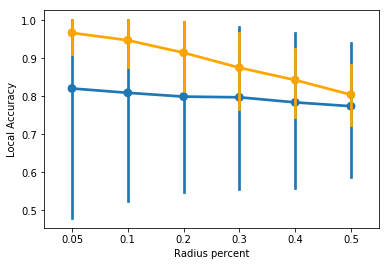

In [41]:
out_localsurr = pandas.DataFrame(localsurrogate)
out_papernot = pandas.DataFrame(papernot)



import seaborn as sns
import matplotlib.pyplot as plt

sns.pointplot(data=out_papernot)
sns.pointplot(data=out_localsurr, color='orange')
plt.xlabel('Radius percent')
plt.ylabel('Local Accuracy')
plt.savefig('figures/local_fidelity_german.pdf')
plt.show()


In [43]:
out_papernot.to_csv('aze.csv')

In [ ]:
from multiprocessing import Pool
def sq(x):
    return sq[0] + sq[1] / sq[0] + sq[1]

with Pool(5) as p:
    print(p.map(sq, [xs_toexplain]))
    
sum(xs_toexplain)